# Neural Cellular Automata

> In this module, we look creating complex emergent behavior by training agents with simple rules

In [1]:
#| default_exp neural_cellular_automata

In [2]:
import random
from functools import partial
from pdb import set_trace as bp

import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from einops import rearrange
from IPython.display import display
from torch import nn, tensor
from tqdm import trange

from slowai.learner import (
    DataLoaders,
    Learner,
    MetricsCB,
    ProgressCB,
    TrainCB,
    TrainLearner,
    def_device,
)
from slowai.style_transfer import GramLoss, pt_normalize_imagenet
from slowai.utils import download_image, show_image, show_images

Complex behavior can emerge from simple rules. Conway's game of life is a famous example.

![](https://upload.wikimedia.org/wikipedia/commons/e/e5/Gospers_glider_gun.gif)

This lesson was inspired by this [distil.pub article](https://distill.pub/2020/growing-ca/) that demonstrates a self-organizing, self-repairing system. How do we train something like this?

This starts with a neural network that takes the cell state and that that of its neighbors and predicts a evolution that leads to a particular image. Unfortunately, this doesn't produce a stable output. We also need to train with random initialization that gives it the ability to correct and maintain its shape.

We'll train a simple texture restoration model, which allows us to leverage the Gram loss from the previous module.

## Defining the model

In [3]:
I = tensor([[0.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 0.0]])
G = tensor([[-1.0, 0.0, 1.0], [-2.0, 1.0, 2.0], [-1.0, 0.0, 0.1]])
S = tensor([[1.0, 2.0, 1.0], [2.0, -12.0, 2.0], [1.0, 2.0, 1.0]])
filters = torch.stack([I, G, G.T, S]).to(def_device)
channels, _, _ = filters.shape

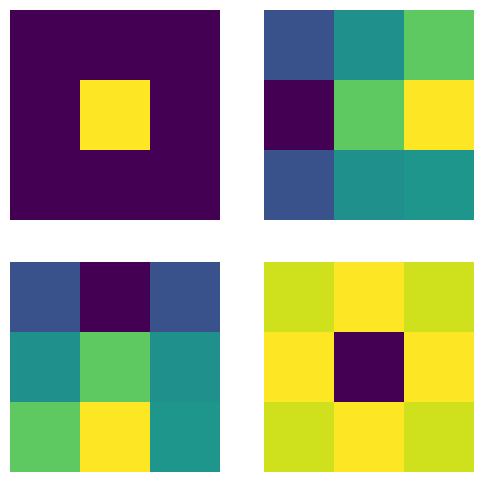

In [4]:
show_images([I, G, G.T, S])

The last filter is called a Sobel operator.

![](https://miro.medium.com/v2/resize:fit:640/format:webp/1*m9XHMKQPY6mKYsaykuVAsw.png)

In [5]:
def make_grid(n, sz=128):
    return torch.zeros(n, channels, sz, sz).to(def_device)

In [6]:
def apply_filters(x):
    b, c, w, h = x.shape
    y = rearrange(x, "b c h w -> (b c) h w").unsqueeze(1)
    y = F.pad(y, (1, 1, 1, 1), "circular")
    y = F.conv2d(y, filters.unsqueeze(1))
    return y.reshape(b, -1, w, h)

In [7]:
grid = make_grid(1)
grid.shape

torch.Size([1, 4, 128, 128])

Our "world" is $128 \times 128$ and each position carries four data points or channels.

In [8]:
x = apply_filters(grid)
x.shape

torch.Size([1, 16, 128, 128])

This gives us 16 model inputs per pixel, which comes from the four filters applied to each of the four channels .

In [9]:
class LinearBrain(nn.Module):
    def __init__(self, grid, nh=8, nc=4, nf=4):
        """NCA update model

        Args:
            grid: grid, needed for shape
            nh: number of hidden dimensions
            nc: number of input channels
            nf: number of filters
        """
        super().__init__()
        layers = [
            # Bias must be true here to break the symmetry of a newly
            # initialized zero-filled grid
            nn.Linear(nc * nf, nh, bias=True),
            nn.ReLU(),
            # The bias is false here because updates should be centered
            # around 0; and, we also want to keep the number of parameters
            # to a minimum
            nn.Linear(nh, nc, bias=False),
        ]
        self.layers = nn.ModuleList(layers)
        self.grid = grid

    def forward(self, x):
        x = rearrange(x, "b c h w -> (b h w) c")
        for layer in self.layers:
            x = layer(x)
        return x.reshape(self.grid.shape)

In [10]:
m = LinearBrain(grid)
m.to(def_device)
m.forward(x).shape

torch.Size([1, 4, 128, 128])

An alernate approach to the reshaping to use a convolution with a kernel size of 1.

In [11]:
class Brain(nn.Module):
    def __init__(self, nh=8, nc=4, nf=4):
        """NCA update model

        Args:
            nh: number of hidden dimensions
            nc: number of input channels
            nf: number of filters
        """
        super().__init__()
        layers = [
            nn.Conv2d(nc * nf, nh, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(nh, nc, kernel_size=1, bias=False),
        ]
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [13]:
m = Brain()
m.to(def_device)
m.forward(x).shape

torch.Size([1, 4, 128, 128])

This is quite elegant! It's also highly performant on GPUs, since they were designed to run matrix operations on each pixel.

## Consolidating the model

Let's put this all into a class

In [14]:
class NCA(Brain):
    @torch.no_grad()
    def init_(self):
        w2 = self.layers[-1]
        w2.weight.data.zero_()

    def forward(self, grid, update_rate=0.5):
        y = apply_filters(grid)
        for layer in self.layers:
            y = layer(y)
        b, c, h, w = y.shape
        # Randomly dropout some updates to reflect the non-global
        # update behavior of biological systems
        y = F.dropout(y, update_rate)
        return grid + y

In [15]:
m = NCA()
m.to(def_device)
x = m.forward(grid)
x.shape, grid.shape

(torch.Size([1, 4, 128, 128]), torch.Size([1, 4, 128, 128]))

## Training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


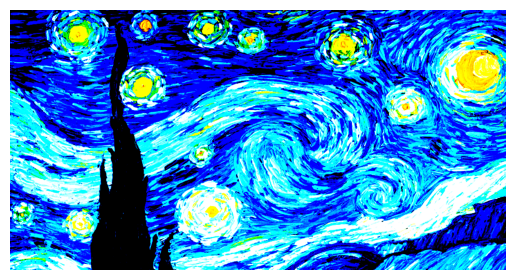

In [16]:
starry_night = "https://sanctuarymentalhealth.org/wp-content/uploads/2021/03/The-Starry-Night-1200x630-1-979x514.jpg"
target = download_image(starry_night)
target = pt_normalize_imagenet(target)
show_image(target);

In [17]:
def to_rgb(x):
    return x[:, :3, :, :] + 0.5

In [18]:
class StyleLoss:
    def __init__(
        self,
        target_img,
        target_layers=(1, 6, 11, 18, 25),
        vgg=None,
    ):
        if vgg is None:
            self.vgg = timm.create_model("vgg16", pretrained=True).to(def_device)
        else:
            self.vgg = vgg
        for p in self.vgg.parameters():
            # No need to train VGG
            p.requires_grad = False

        self.target_layers = target_layers

        with torch.no_grad():
            self.tgt = self.grams(target_img.to(def_device))

    def grams(self, x):
        x = pt_normalize_imagenet(x)
        if len(x) < 4:
            x = x.unsqueeze(0)
        grams_ = []
        for i, layer in enumerate(self.vgg.features[: max(self.target_layers) + 1]):
            b, c, h, w = x.shape
            x = layer(x)
            if i in self.target_layers:
                f = x.clone()  # Not sure if I need this
                g = torch.einsum("bchw, bdhw -> bcd", f, f) / (h * w)
                grams_.append(g)
        return grams_

    def __call__(self, img):
        src = self.grams(img)
        # Writing MSE out manually here helps by broadcasting the style gram
        # matrices to each of the sample image gram matrices
        return sum((f1 - f2).pow(2).mean() for f1, f2 in zip(src, self.tgt))

In [19]:
loss_f = StyleLoss(torch.randn((3, 64, 64)).to(def_device))

In [21]:
def train(
    stlye_img,
    style_loss_scale=0.1,
    n=128,
    sz=256,
    bs=4,
    step_n_min=32,
    step_n_max=96,
    lr=1e-3,
    train_iterations=1200,
    model_application_iterations=(32, 96),
):
    nca = NCA()
    nca.to(def_device)
    nca.init_()
    pool = make_grid(n, sz=sz).to(def_device)
    loss_f = StyleLoss(stlye_img)
    opt = torch.optim.Adam(nca.parameters(), lr)

    ipy_output = None
    K = 3.5
    fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(K * 3, K))
    losses = []

    pbar = trange(train_iterations)
    for i in pbar:
        # Subsample with replacement
        subpool_idxs = torch.randint(0, n, (bs,))
        subpool = pool[subpool_idxs]

        # Randomly zero out samples
        if random.random() > 0.8:
            subpool[:1] = make_grid(1, sz=sz).to(def_device)

        # Apply the model
        min_, max_ = model_application_iterations
        n_iterations = random.randrange(min_, max_ + 1)
        for _ in range(n_iterations):
            subpool = nca(subpool)

        if i > 0:
            assert not (subpool == 0).all()

        # Update the pool
        with torch.no_grad():
            pool[subpool_idxs] = subpool

        # Compute loss
        style_loss = loss_f(to_rgb(subpool)) * style_loss_scale
        overflow_loss = (subpool - subpool.clamp(-1.0, 1.0)).abs().sum()
        loss = style_loss + overflow_loss
        losses.append((loss.item(), style_loss.item(), overflow_loss.item()))

        pbar.set_description(f"{style_loss.item():.2f} {overflow_loss.item():.2f}")
        if i % 100 == 0 and i > 0:
            x = range(0, i + 1)
            combined, style_losses, overflow_losses = zip(*losses)
            for ax, y, label in [
                (a0, style_losses, "style"),
                (a1, overflow_losses, "overflow"),
                (a2, combined, "overall"),
            ]:
                ax.clear()
                ax.scatter(x, y, label=label)
                ax.set_yscale("log")
                ax.legend()
            fig.tight_layout()

            if ipy_output is None:
                ipy_output = display(fig, display_id=True)
            else:
                ipy_output.update(fig)

        # Backprop with gradient normalization
        loss.backward()
        for p in nca.parameters():
            p.grad /= p.grad.norm() + 1e-8
        opt.step()
        opt.zero_grad()

    return nca, pool.detach()

1258.36 34410.16:   9%|███████████▎                                                                                                                  | 108/1200 [00:10<01:28, 12.38it/s]

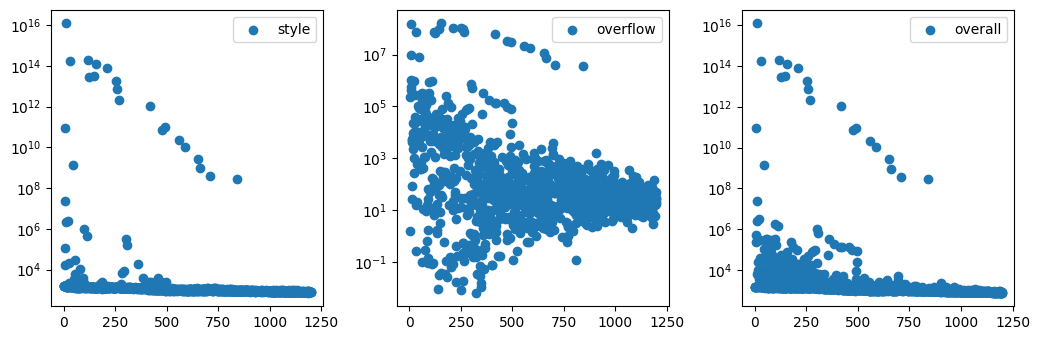

750.20 28.38: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [01:56<00:00, 10.28it/s]


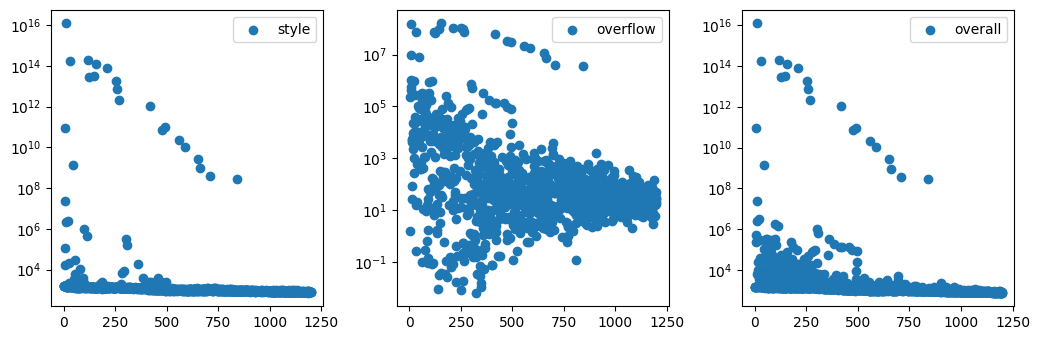

In [22]:
model, pool = train(target)

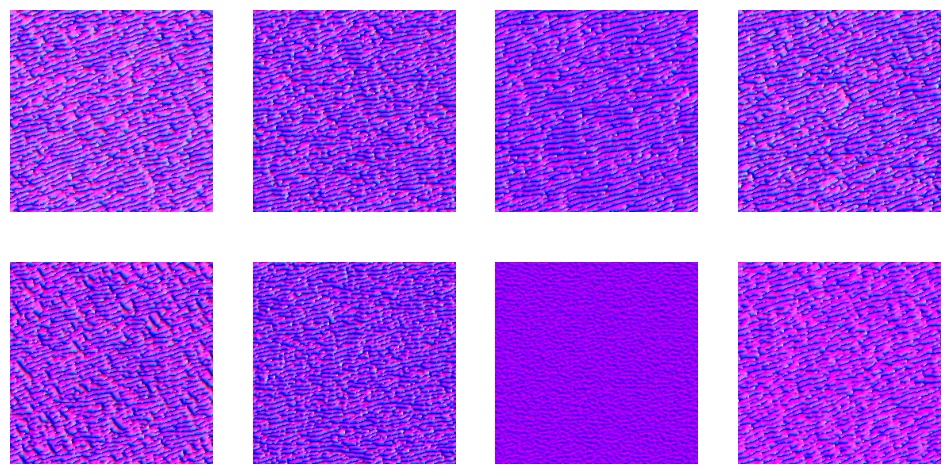

In [23]:
show_images(to_rgb(pool).clip(0, 1)[:8, ...])

Starting from an empty grid

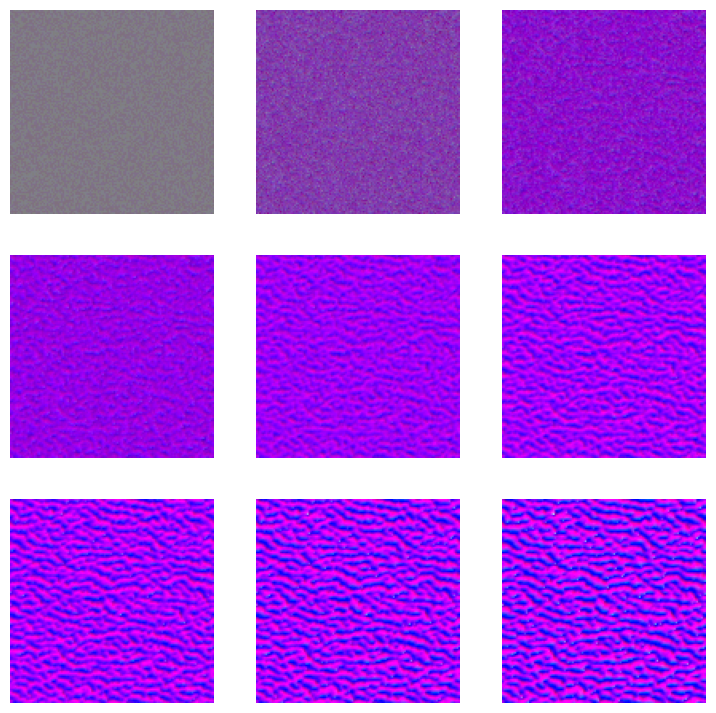

In [26]:
images = []
x = make_grid(n=1)
for i in range(90):
    x = model(x)
    if i % 10 == 0:
        imgs = to_rgb(x).clip(0, 1).squeeze()
        images.append(imgs)
show_images(images)

In [25]:
#| hide
import nbdev

nbdev.nbdev_export()